Instalacion de dependencias

In [1]:
pip install pandas matplotlib seaborn scikit-learn openpyxl graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

In [24]:
file = 'Pruebas experimentales del rotavapor RCL.xlsx'
sheet = 'Datos'

try:
    df = pd.read_excel(file, sheet_name=sheet)
except FileNotFoundError:
    print(f"Error: The file '{file}' was not found.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    exit()

tabla = df.iloc[12:, 2:]
tabla.columns = df.iloc[11, 2:]
tabla.reset_index(drop=True, inplace=True)

print("Column names:", tabla.columns.tolist())
print(tabla)

Column names: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Masa Agua', 'Tasa de evaporación']
11   X1 X2   X3 X4    X5     X6    X7 Masa Agua Tasa de evaporación
0    80  3  200  8  4.26  0.052  6.54   189.814                 NaN
1    60  2  150  8  4.33   0.04  6.54   102.816                 NaN
2    60  1  200  8  4.33  0.052  6.54    78.214                 NaN
3    70  2  200  8  4.28  0.052  6.54   177.115                 NaN
4    70  1  250  8  4.28  0.076  6.54   158.054                 NaN
..   .. ..  ... ..   ...    ...   ...       ...                 ...
107  85  2  275  8  4.25  0.082  6.54   216.333                 NaN
108  65  2  275  8   4.3  0.082  6.54   170.492                 NaN
109  75  1  175  8  4.27  0.046  6.54   186.669                 NaN
110  65  3  225  8   4.3  0.064  6.54   175.175                 NaN
111  65  2  225  6   4.3  0.064  6.56   177.439                 NaN

[112 rows x 9 columns]


In [25]:
features = ["X1", "X2", "X3", "X4", "X5", "X6", "X7"]
target = "Masa Agua"

# Arbol de decision

In [26]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

def decisionTreeF(data):
    X = data[features]
    y = data[target]

    decisionTree = DecisionTreeRegressor(random_state=42)
    decisionTree.fit(X, y)

    # Metrica de R²
    r2_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='r2')
    print("R² en validación cruzada:", r2_scores)
    print("Promedio R²:", np.mean(r2_scores))

    # Metrica de MAE
    mae_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='neg_mean_absolute_error')
    print("MAE en validación cruzada:", -mae_scores)
    print("Promedio MAE:", -np.mean(mae_scores))

    # Metrica de RMSE
    rmse_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print("RMSE en validación cruzada:", -rmse_scores)
    print("Promedio RMSE:", -np.mean(rmse_scores))

    return decisionTree



In [27]:
decisionTreeF(tabla)

R² en validación cruzada: [ 0.77119059  0.16463218 -1.11642021  0.46999635  0.19294081]
Promedio R²: 0.09646794453813305
MAE en validación cruzada: [13.8173913  18.79163043 19.72997727 12.29199091 10.57509091]
Promedio MAE: 15.041216166007905
RMSE en validación cruzada: [17.60864995 39.14539777 40.4744579  13.6929589  13.37440561]
Promedio RMSE: 24.859174027040623


DecisionTreeRegressor(random_state=42)

In [30]:
import graphviz
from sklearn.tree import export_graphviz

def dibujar_arbol(data, name, deep):
    X = data[features]
    y = data[target]

    decisionTree = DecisionTreeRegressor(random_state=42, max_depth=deep)
    decisionTree.fit(X, y)

    # Metrica de R²
    r2_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='r2')
    print("R² en validación cruzada:", r2_scores)
    print("Promedio R²:", np.mean(r2_scores))

    # Metrica de MAE
    mae_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='neg_mean_absolute_error')
    print("MAE en validación cruzada:", -mae_scores)
    print("Promedio MAE:", -np.mean(mae_scores))

    # Metrica de RMSE
    rmse_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print("RMSE en validación cruzada:", -rmse_scores)
    print("Promedio RMSE:", -np.mean(rmse_scores))

    export_graphviz(decisionTree, out_file=f"{name}_tree.dot", feature_names=features, filled=True)

In [31]:
dibujar_arbol(tabla, "DecisionTree", 3)

R² en validación cruzada: [0.8160099  0.33622851 0.53393792 0.57143484 0.71646962]
Promedio R²: 0.5948161561058316
MAE en validación cruzada: [11.56134262 16.51369709 12.81294756 10.08740348  6.34889723]
Promedio MAE: 11.464857594816038
RMSE en validación cruzada: [15.79015349 34.89403071 18.99336775 12.31306872  7.92723253]
Promedio RMSE: 17.983570639610285


# Random Forest

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def randomForest(data):
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    
    # Métricas de regresión
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Métricas del modelo:")
    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

    # Gráfico de predicciones vs valores reales
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Predicciones vs Valores Reales')
    plt.grid(True, alpha=0.3)

    # Gráfico de residuos
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Gráfico de Residuos')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Evaluar importancia de las variables
    importances = rf.feature_importances_
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    print("\nImportancia de Variables:")
    print(feature_importance)

    # Graficar importancia de las variables
    plt.figure(figsize=(8,6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importancia')
    plt.title('Importancia de Variables en el Modelo Random Forest')
    plt.gca().invert_yaxis()
    plt.show()
    
    return rf

Métricas del modelo:
MAE: 6.990
MSE: 77.712
RMSE: 8.815
R²: 0.651


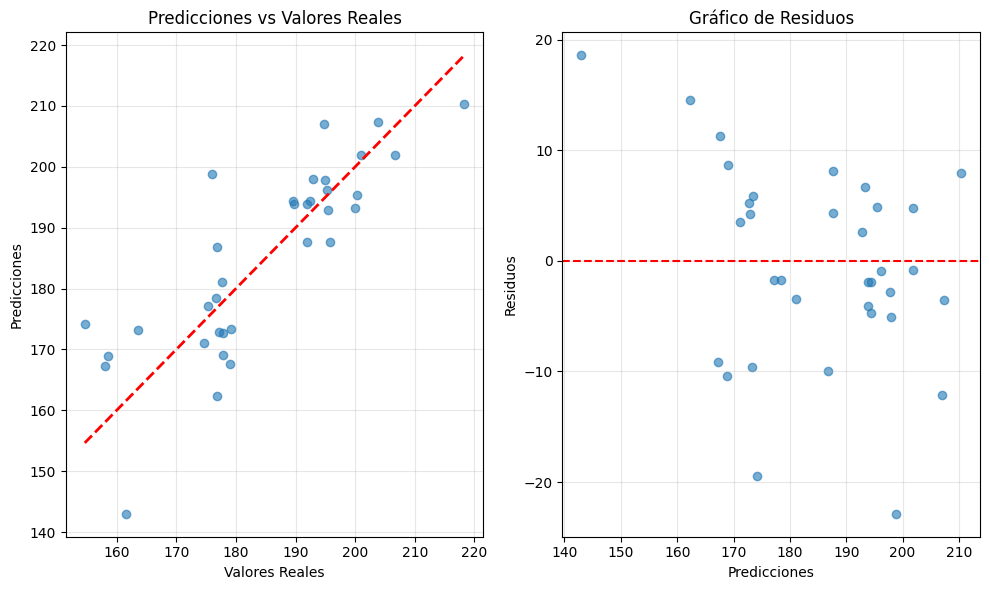


Importancia de Variables:
  Feature  Importance
0      X1    0.395131
4      X5    0.301696
1      X2    0.092338
3      X4    0.067686
2      X3    0.048563
5      X6    0.048441
6      X7    0.046146


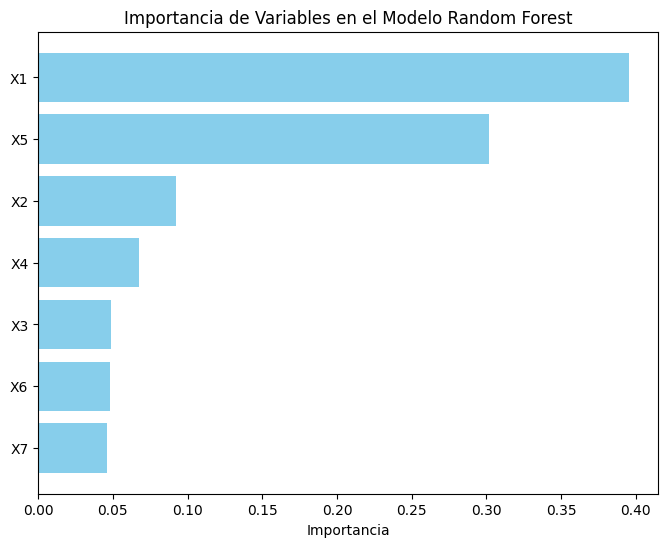

RandomForestRegressor(random_state=42)

In [29]:
randomForest(tabla)